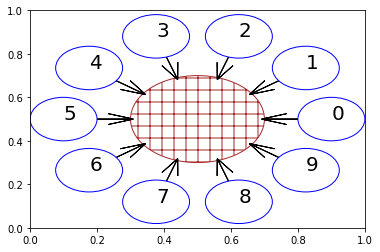

# Pass the Peas
## a simple example of collective cognition


---



In [ ]:
!pip install mesa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 691 kB 5.2 MB/s 
     |████████████████████████████████| 596 kB 36.3 MB/s 
     |████████████████████████████████| 64 kB 2.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


As a first pass at agent-based computational modeling, I will consider a dinner table wherein the people at the dinner are eating with dishes in front of them. A dish may only be swapped with another, and one agent may only have one dish at a time.

When there is a "request" send out from one of the agents for a particular dish, all other agents immediately use their own agency (the ability to see around the table, the ability to pass left or right) to realize the desired outcome of the requester receiving the correct dish.

In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import SingleGrid

dishes = ["peas","corn","cranberry sauce","turkey","pie","mashed potatoes","green beans","rolls","carrots","pizza","caviar","fried haddock","turtle soup"]

Now that Mesa is installed and imported, we build our Agent and Model classes.

In [ ]:
class DinnerAgent(Agent):
    """ An agent with a unique ID corresponding to their given dish """
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        # the dish the agent starts with is matched with their id
        self.dish = dishes[self.unique_id]
        # the agent is not aware of any requester
        self.requester = None
        # the agent is not aware of any requested dish
        self.requestedDish = None
        
        
    def step(self):
        #print("This is dinner agent " + str(self.unique_id) + ", I have the " + self.dish + ".")
        if self.requestedDish and self.requester:
            #print("request has been recognized for Agent " + str(self.unique_id) + ".")
            if self.isHolding():
                if self.unique_id == self.requester.unique_id:
                    print(str(self.unique_id) + ": No need for anyone to pass me the " + self.requestedDish + ", I have the " + self.requestedDish + ".")
                    self.cancelRequest()
                else:
                    print(str(self.unique_id) + ": I have the " + self.requestedDish + " for " + str(self.requester.unique_id) + ".")
                    self.passDish()
            else:
                 print(str(self.unique_id) + ": I do not have the " + self.requestedDish + " for " + str(self.requester.unique_id) + ".")
            
    def cancelRequest(self):
        self.requestedDish = None
        self.requester = None
            
    def isHolding(self):
        if self.dish == self.requestedDish:
            return True
        else:
            return False
    
    def updateRequest(self, requestedDish, requester):
        self.requestedDish = requestedDish
        self.requester = requester
        
    def passDish(self):
        #print("passing....")
        """ first determine whether left or right will be most efficient """
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        step_options = [abs(self.requester.unique_id-step[0]) for step in possible_steps]
        min_steps = step_options.index(min(step_options))
        other_agent = self.model.schedule.agents[possible_steps[min_steps][0]]
        print(str(self.unique_id) + ": swapping dishes with Agent " + str(other_agent.unique_id) + " who has " + other_agent.dish + ".")
        self.swapDishes(other_agent.unique_id)
        print(str(self.unique_id) + ": Agent " + str(other_agent.unique_id) + " has " + other_agent.dish + " after the swap, I have " + self.dish)
    
    """ helper method for swapping dishes """
    def swapDishes(self, swapper_id):
        #print("swapping....")
        temp = self.model.schedule.agents[self.unique_id].dish
        self.model.schedule.agents[self.unique_id].dish = self.model.schedule.agents[swapper_id].dish
        self.model.schedule.agents[swapper_id].dish = temp
        
        
class DinnerModel(Model):
    """ A model of agents at a circular dinner table, each with a dish """
    
    def __init__(self, N):
        self.num_agents = N
        self.requestedDish = None
        self.requester = None
        self.dishHolder = None
        self.grid = SingleGrid(N, 1, True)
        self.schedule = RandomActivation(self)
        # make the agents
        for i in range(self.num_agents):
            a = DinnerAgent(i, self)
            self.schedule.add(a)
            """ add agents to grid """
            x = a.unique_id
            self.grid.place_agent(a, (x, 0))
        # randomize pea placement in case that's chosen
        self.schedule.agents[0].swapDishes(self.random.choice(self.schedule.agents).unique_id)
            
    def step(self):
        self.schedule.step()
        cancelled = False
        """ Display agents and their dishes """
        for a in self.schedule.agents:
            print("Agent " + str(a.unique_id) + " has " + a.dish + ".")
            if a.requester == None or a.requestedDish == None:
                """ if one agent has set their request variables to None, the requests must all be cancelled """
                if not cancelled:
                    self.cancelAll()
                    cancelled = True
            else:
                if a.dish == a.requestedDish:
                    self.dishHolder = a
                
    def request(self):
        self.requester = input("Please type the number of an Agent to make a request (push enter for a random choice): ")
        if self.requester == "":
            self.requester = self.random.choice(self.schedule.agents)
        else:
            self.requester = self.schedule.agents[int(self.requester)]
        self.requestedDish = input("Please request a dish (default 'peas', just push enter): ")
        if self.requestedDish == "":
            self.requestedDish = "peas"
        print("Agent requesting " + self.requestedDish + " is " + str(self.requester.unique_id) + ".")
        """ percolate request to all agents """
        for a in self.schedule.agents:
            a.updateRequest(self.requestedDish, self.requester)
            
    def cancelAll(self):
        print("Experimenter: The dish has been passed.")
        self.requestedDish = None
        self.requester = None
        self.dishHolder = None
        for a in self.schedule.agents:
            a.cancelRequest()
        

Once this block is run, we can test.

In [ ]:
test_model = DinnerModel(10)
test_model.request()

Please type the number of an Agent to make a request (push enter for a random choice): 
Please request a dish (default 'peas', just push enter): 
Agent requesting peas is 0.


Now the model is loaded, and there is a request active, we can run all the agents once with a step.

In [ ]:
test_model.step()



---



## Visualization

Using matplotlib, we can represent the situation in pictures, with a table in the middle surrounded by the dinner agents, each with a dish.

Our drawing is extremely simplified, with the table an oblong ellipse in the center, surrounded by circular agents with arrows indicating the object of their attention.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

""" helper function to convert to polar for even spacing around the table """
def polarConvert(pos, n, o1, o2):
    angle = (pos[0]/n) * 2 * np.pi 
    radius = 0.4
    
    x = radius * np.cos( angle ) + o1
    y = radius * np.sin( angle ) + o2

    return (x,y)

def visualize(model):
    fig, ax = plt.subplots()

    # draw the table in the middle
    circle2 = plt.Circle((0.5, 0.5), 0.2, facecolor='white', edgecolor='brown', hatch='+')
    ax.add_patch(circle2)

    # iterate over all agents in model
    for a in model.schedule.agents:   
        n = test_model.num_agents     
        o1 = 0.5
        o2 = 0.5
        x,y = polarConvert(a.pos,n,o1,o2)
        circleColor = 'blue'

        # handle all cases
        if a.dish == a.requestedDish:
            if a != test_model.requester and test_model.requester != None:
                hx, hy = polarConvert(test_model.requester.pos,n,o1,o2)
                dx = hx - x
                dy = hy - y
                circleColor = 'green'
            else:
                dx = o1 - x
                dy = o2 - y
                circleColor = 'green'
        else:
            if test_model.dishHolder != None:
                hx, hy = polarConvert(test_model.dishHolder.pos,n,o1,o2)
            else:
                if test_model.requester != None:
                    hx, hy = polarConvert(test_model.requester.pos,n,o1,o2)
                else:
                    hx, hy = o1, o2
            dx = hx - x
            dy = hy - y
        # draw the individual agent
        scale = 3
        ax.add_patch(mpatches.FancyArrow(x, y, dx/scale, dy/scale, overhang=1, head_width=0.05))
        ax.add_patch(plt.Circle((x,y), 0.1, facecolor='white', edgecolor=circleColor))
        ax.text(x, y, str(a.unique_id), fontsize=20)

test_model = DinnerModel(10)
visualize(test_model)

NameError: ignored

Please type the number of an Agent to make a request (push enter for a random choice): 3
Please request a dish (default 'peas', just push enter): peas
Agent requesting peas is 3.


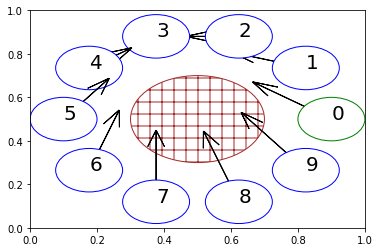

In [ ]:
test_model.request()
visualize(test_model)

9: I do not have the peas for 3.
8: I do not have the peas for 3.
2: I do not have the peas for 3.
5: I do not have the peas for 3.
0: I do not have the peas for 3.
6: I do not have the peas for 3.
1: I do not have the peas for 3.
3: No need for anyone to pass me the peas, I have the peas.
4: I do not have the peas for 3.
7: I do not have the peas for 3.
Agent 0 has corn.
Agent 1 has cranberry sauce.
Agent 2 has turkey.
Agent 3 has peas.
Experimenter: The dish has been passed.
Agent 4 has pie.
Agent 5 has mashed potatoes.
Agent 6 has green beans.
Agent 7 has rolls.
Agent 8 has carrots.
Agent 9 has pizza.


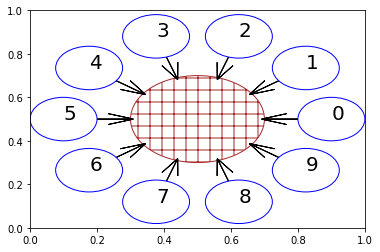

In [ ]:
test_model.step()
visualize(test_model)

## Modeling using decentralized partially observable Markov decision process (Dec-POMDP)

Using the Dec-POMDP tuple $M=<I,S,\{A_i\},P,R,\{Ω_i\},O,h>$

For which:
*   $I$, the set of agents
*   $S$, the set of states with initial state $s_0$
*   $A_i$, the set of actions for agent $i$, with $A = x_i A_i$ the set of joint actions
*   $P$, the state transition probabilities: $P(s'| s, a)$, the probability of the environment transitioning to state $s'$ given it was in state s and agents took actions $a$
*   $R$, the global reward function: $R(s, a)$, the immediate reward the system receives for being in state s and agents taking actions a
*   $Ω_i$, the set of observations for agent $i$, with $Ω = x_i Ω_i$ the set of joint observations
*   $O$, the observation probabilities: $O(o| s, a)$, the probability of agents seeing observations o, given the state is s and agents take actions a
*   $h$, the horizon, whether infinite or if finite, a positive integer
when h is infinite a discount factor, $0 \leq γ < 1$ , is used 


A big question comes up when we consider this particular application, are we using a Dec-POMDP or a Dec-MDP? In this case, each agent can see the whole table, who has what dish, who is requesting it, etc. Therefore it doesn't really make sense to use a Partially-Observable Markov Decision Process, but rather a Markov Decision Process, which is itself a subset of Dec-POMDPs.

In practice, it makes sense that when modeling collective cognition (Kraft, 2019) we would use a Partially Observable process, since each member of the collective has their own perspective, observations, possible actions, and their information is incomplete.

However, for this simple example this is not the case, all agents have all the information, so instead we will use the Dec-MDP tuple $M=<S,A,P,R>$

For which:
*   $S$ is a finite set of states, with distinguished initial state $s_0$
*   $A$ is a finite set of actions
*   $P: S \times A → \Delta S$ is a Markovian transition function.
  $P(s'|s,a)$ denotes the probability that taking action $a$ in state $s$ will result in a transition to state $s'$.
*   $R: A \times S \rightarrow \mathbb{R}$ is a reward function.
  $R(a,s')$ denotes the reward obtained when action $a$ is taken and a state transition to $s'$ occurs.

Our Markov assumption is $P(s_t|s_{t-1},s_{t-2},\ldots ,s_0,a) = P(s_t|s_{t-1},a)$

In terms of our policy $\pi$ to map states to actions, we can use the following as our expected value function, given that our horizon is finite:
$V^{\pi}(s_0)=E[\sum_{t=0}^{h-1}R(\pi(s_t),s_{t-1})]$

Our optimal policy (Bellman equation, Bellman, 1957) is defined by:

$\pi^*(s)=\max_a \sum_{s'}p(s'|s,a)V(s')$

and $V(s)=R(s)+γ\max_a \sum_{s'}p(s'|s,a)V(s')$


(Adapted from Spaan, Amato, and Zilberstein's "Decision Making in Multiagent Settings: Team Decision Making" 2011, accessed at http://users.isr.ist.utl.pt/%7Emtjspaan/tutorialDMMS/tutorialAAMAS11.pdf on June 9th, 2022)

To make our lives easier (hopefully), we'll use a Markov Decision Process Toolbox! (https://pymdptoolbox.readthedocs.io/en/latest/)

In [ ]:
!pip install pymdptoolbox
!pip install mesa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 691 kB 3.8 MB/s 
     |████████████████████████████████| 596 kB 37.0 MB/s 
     |████████████████████████████████| 64 kB 1.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Reevaluating states from previous assumptions

The addition of "looking" as a parameter has lead to a reevaluation of possible/interesting states in this problem. Previously I considered "neutral" a possible state, with "holding" and "receiving" being the other two. With the addition of an embodied affordance, looking, it is clear that instead of one state there are at least two in this behavior: engaged and distracted.

When at a table, especially one with many people, it may be easy to become distracted, either with eating, conversation, a bat which has suddenly flown into the room, etc. So distraction is a real possiblility which will increase with the distance from the person in the "requesting" state. Distraction is reduced by neighboring agents in an engaged state, and if they are immediate neighbors engaged in "passing" to that agent the distraction state is immediately avoided.

To be other than distracted is to be engaged, by which is meant focused on the table and the people at it. If someone requests a dish, an engaged person would notice (usually) and take actions which will work to that effect. In addition engaged agents can reduce distraction with their gaze, by looking at a distracted agent and reducing their distraction.

### Reevaluating actions

In fact, my actions were also initially in error, it seemed to pass, to recieve, to request, or to do nothing were the only actions. Upon further consideration it makes more sense to go outside the safe confines of the finite state machine and imagine embodied actors reaching for the food on the table. In fact, identification of the food on the table must be part of the pattern. This is nice since swapping never seemed right to begin with.

In [ ]:
from mesa import Agent,Model
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mdptoolbox import mdp
import numpy as np
from scipy.sparse import csr_matrix as sparse

class DinnerAgent(Agent):
    """ An agent with a unique ID corresponding to their given dish """

    """ for mdptoolbox each Transition probability matrix must be indexable like: transitions[a] """
    """ where aE{0,1,...,A-1} and transitions[a] returns an SxS array, A= # of actions S = # of states"""
    """ S = 5 and A = 5 """

    """ for mdptoolbox each Reward probability must be indexable like: reward[a] """
    """ where reward is a tuple of length A """

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

        """ some initial probabilities """
        e_prob = 0.5 # the probability of being engaged after performing an action
        e_factor = 2 # the factor by which being engaged makes it more likely a request will be made
        l_prob = 0.8 # the probability that an engaged person will look for the dish actively upon request
        r_prob = 0.1 # the probability of requesting a dish
        states = ["distracted", "engaged", "holding", "requesting", "looking"]
        actions = ["pass", "request", "get", "find", "nothing"]

        """ PROBABILITY MATRICES """
        pass_prob = sparse([[1.0,0.0,0.0,0.0,0.0],
                    [0.0,1.0,0.0,0.0,0.0],
                    [1-e_prob,e_prob,0.0,0.0,0.0],
                    [0.0,0.0,0.0,1.0,0.0],
                    [0.0,0.0,0.0,0.0,1.0]])
        request_prob = sparse([[0.0,0.0,0.0,1.0,0.0],
                    [0.0,0.0,0.0,1.0,0.0],
                    [0.0,0.0,0.0,1.0,0.0],
                    [0.0,0.0,0.0,1.0,0.0],
                    [0.0,0.0,0.0,1.0,0.0]])
        get_prob = sparse([[0.0,0.0,1.0,0.0,0.0],
                    [0.0,0.0,1.0,0.0,0.0],
                    [0.0,0.0,1.0,0.0,0.0],
                    [0.0,0.0,1.0,0.0,0.0],
                    [0.0,0.0,1.0,0.0,0.0]])
        find_prob = sparse([[0.0,0.0,0.0,0.0,1.0],
                    [0.0,0.0,0.0,0.0,1.0],
                    [0.0,0.0,0.0,0.0,1.0],
                    [0.0,0.0,0.0,0.0,1.0],
                    [0.0,0.0,0.0,0.0,1.0]])
        nothing_prob = sparse([[(1-e_prob)-(r_prob/2),(e_prob-(r_prob/2)),0.0,r_prob,0.0],
                    [(1-e_prob)-((r_prob*e_factor)/2),(e_prob-((r_prob*e_factor)/2)),0.0,e_factor*r_prob,0.0],
                    [0.0,0.0,1.0,0.0,0.0],
                    [0.0,0.0,0.0,1.0,0.0],
                    [0.0,0.0,0.0,0.0,1.0]])
        self.transitions = sparse([pass_prob, request_prob, get_prob, find_prob, nothing_prob])

        """ REWARD VECTORS """
        pass_reward = sparse([0.0,0.0,1.0,0.0,0.0])
        request_reward = sparse([1-r_prob,r_prob,0.0,0.0,0.0])
        get_reward = sparse([0.1,0.1,0.0,0.4,0.4])
        find_reward = sparse([0.0,0.4,0.0,0.1,0.5])
        nothing_reward = sparse([1.0,0.0,0.0,0.0,0.0])
        self.rewards = sparse([pass_reward, request_reward, get_reward, find_reward, nothing_reward])

        #mdp.FiniteHorizon(transitions, rewards, discount, N, h, skip_check, [value_function_array, policy_array, cpu_time])
        #self.MDP = mdp.MDP(transitions, rewards, discount, epsilon, max_iter)
        self.MDPsolution = mdp.ValueIteration(self.transitions, self.rewards, 0.9)
        #self.MDPsolution.setVerbose()
        self.MDPsolution.run()
        print(str(self.unique_id) + " Policy: " + str(self.MDPsolution.policy))
        self.MDPsolution.run()
        print(str(self.unique_id) + " Policy: " + str(self.MDPsolution.policy))
        
    def step(self):
        self.MDPsolution.run()
        print(self.MDPsolution.policy)
        
        
class DinnerModel(Model):
    """ A model of agents at a circular dinner table, each with a dish """
    
    def __init__(self, N):
        self.num_agents = N
        self.requestedDish = None
        self.requester = None
        self.grid = SingleGrid(N, 1, True)
        self.schedule = RandomActivation(self)
        # make the agents
        for i in range(self.num_agents):
            a = DinnerAgent(i, self)
            self.schedule.add(a)
            """ add agents to grid """
            x = a.unique_id
            self.grid.place_agent(a, (x, 0))
            
    def step(self):
        self.schedule.step()
        """ Display agents and their dishes """
        for a in self.schedule.agents:
            print("Agent " + str(a.unique_id) + " has " + a.dish + ".")
            if a.requester == None or a.requestedDish == None:
                """ if one agent has set their request variables to None, the requests must all be cancelled """
                self.cancelAll()
                
    def request(self):
        self.requester = input("Please type the number of an Agent to make a request (push enter for a random choice): ")
        if self.requester == "":
            self.requester = self.random.choice(self.schedule.agents)
        else:
            self.requester = self.schedule.agents[int(self.requester)]
        self.requestedDish = input("Please request a dish (default 'peas', just push enter): ")
        if self.requestedDish == "":
            self.requestedDish = "peas"
        print("Agent requesting " + self.requestedDish + " is " + str(self.requester.unique_id) + ".")
        """ percolate request to all agents """
        for a in self.schedule.agents:
            a.updateRequest(self.requestedDish, self.requester)
            
    def cancelAll(self):
        self.requestedDish = None
        self.requester = None
        for a in self.schedule.agents:
            a.cancelRequest()
        

In [ ]:
test_model = DinnerModel(2)

ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

""" helper function to convert to polar for even spacing around the table """
def polarConvert(pos, n, o1, o2):
    angle = (pos[0]/n) * 2 * np.pi 
    radius = 0.4
    
    x = radius * np.cos( angle ) + o1
    y = radius * np.sin( angle ) + o2

    return (x,y)

def visualize(model):
    fig, ax = plt.subplots()

    # draw the table in the middle
    circle2 = plt.Circle((0.5, 0.5), 0.2, facecolor='white', edgecolor='brown', hatch='+')
    ax.add_patch(circle2)

    # iterate over all agents in model
    for a in model.schedule.agents:   
        n = test_model.num_agents     
        o1 = 0.5
        o2 = 0.5
        x,y = polarConvert(a.pos,n,o1,o2)
        circleColor = 'blue'

        # handle all cases
        if a.dish == a.requestedDish:
            if a != test_model.requester and test_model.requester != None:
                hx, hy = polarConvert(test_model.requester.pos,n,o1,o2)
                dx = hx - x
                dy = hy - y
                circleColor = 'green'
            else:
                dx = o1 - x
                dy = o2 - y
                circleColor = 'green'
        else:
            if test_model.dishHolder != None:
                hx, hy = polarConvert(test_model.dishHolder.pos,n,o1,o2)
            else:
                if test_model.requester != None:
                    hx, hy = polarConvert(test_model.requester.pos,n,o1,o2)
                else:
                    hx, hy = o1, o2
            dx = hx - x
            dy = hy - y
        # draw the individual agent
        scale = 3
        ax.add_patch(mpatches.FancyArrow(x, y, dx/scale, dy/scale, overhang=1, head_width=0.05))
        ax.add_patch(plt.Circle((x,y), 0.1, facecolor='white', edgecolor=circleColor))
        ax.text(x, y, str(a.unique_id), fontsize=20)

## Active Inference / Bayesian Model